---
# Acrobot - Policy Gradient
---

In [107]:
%matplotlib notebook  
import tensorflow as tf
import gym
import numpy as np
import random
import matplotlib.pyplot as plt

In [108]:
env = gym.make('Acrobot-v1')

In [109]:
import sys

In [110]:
save_file = 'C:\\Users\\김민수\\Documents\\GitHub\\RL\\vars\\acrobot_pg'

---
# 학습 안한 랜덤 agent
---

In [111]:
ep = 0
while ep < 2:
    step = 0
    env.reset()
    done = False

    while not done:      
        state, r, d, _ = env.step(env.action_space.sample())
        env.render()

        if d:
            ep += 1
            done = True
            env.reset()
env.close()

In [112]:
import io
import base64
from IPython.display import HTML

video = io.open('C:\\Users\\김민수\\Documents\\Bandicam\\acrobot_unedu.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
<source src="data:video/mp4;base64,{0}" type="video/mp4" /> </video>'''.format(encoded.decode('ascii')))

---
# Policy Gradient
---

In [82]:
size_in = env.observation_space.shape[0]
size_out = env.action_space.n
size_w1 = 8
size_w2 = 12
size_w3 = 6

lr = .1
total_episode = 100000
epsilon = 1
gamma = .95

reward = tf.placeholder(tf.float32)
STATE_IN = tf.placeholder(tf.float32, [None, size_in])
W_1 = tf.Variable(tf.random_normal([size_in, size_w1],stddev=.01), name='W_1')
W_2 = tf.Variable(tf.random_normal([size_w1, size_w2],stddev=.01), name='W_2')
W_3 = tf.Variable(tf.random_normal([size_w2, size_w3],stddev=.01), name='W_3')
out = tf.Variable(tf.random_normal([size_w3, size_out],stddev=.01), name='W_out')

In [83]:
L_1 = tf.matmul(STATE_IN, W_1)
L_2 = tf.matmul(L_1, W_2)
L_3 = tf.matmul(L_2, W_3)
L_out = tf.tanh(tf.matmul(L_3, out)) ##활성화함수가 tanh - 

loss = tf.reduce_mean(tf.log(L_out)*reward)
train = tf.train.AdamOptimizer(lr).minimize(loss)

In [84]:
def discounted_reward(r):
    dr = np.zeros_like(r)
    sum_r = 0
    
    for i in reversed(range(0, r.size)):
        sum_r = gamma*sum_r + r[i]
        dr[i] = sum_r  
    
    return dr

In [85]:
'''
그래프 그리기1
'''
def make_graph(x, y):
    plt.ion()
    fig = plt.figure()
    sp = fig.add_subplot(111)
    plt.xlim([0, 500])
    plt.ylim([-500, 0])
    line, = plt.plot(x, y, 'b')
    sp.set_xlabel('episode')
    sp.set_ylabel('reward')
    return fig, sp, line

<IPython.core.display.Javascript object>


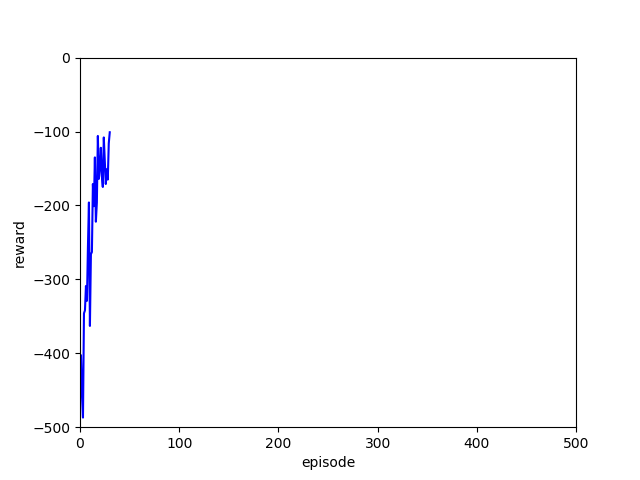

1 -402.0
2 -456.0
3 -486.0
4 -345.0
5 -341.0
6 -308.0
7 -328.0
8 -255.0
9 -195.0
------------ 1.0 평균 : -347.8 ------
10 -362.0
11 -265.0
12 -262.0
13 -170.0
14 -200.0
15 -134.0
16 -221.0
17 -195.0
18 -105.0
19 -163.0
------------ 2.0 평균 : -186.3 ------
20 -148.0
21 -121.0
22 -159.0
23 -174.0
24 -107.0
25 -139.0
26 -170.0
27 -150.0
28 -164.0
29 -115.0
------------ 3.0 평균 : -139.9 ------
------ 학습종료 -------
---- 파라미터 저장 ----
30 -100.0


In [97]:
saver = tf.train.Saver()

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    state_buffer = []
    reward_buffer = []
    ep = 0
    state = env.reset()
    reward_sum = 0
    step = 0
    is_render = False
    mean_ep_reward = 0
    is_trained = False
    
    # 그래프 생성
    x_data = []
    y_data = []
    fig, sp, line = make_graph(x_data, y_data)

    
    while not is_trained:
        done = False
        
        while not done:
            
            step = step + 1
            state = np.reshape(state, [1, size_in])
            state_buffer.append(state)

            if(random.random() < epsilon):
                action = env.action_space.sample()
            else:
                pi = sess.run(L_out, feed_dict={STATE_IN:state})
                action = np.argmax(pi)

            new_state, r, d, _ = env.step(action)
            state = new_state
            reward_sum += r
            reward_buffer.append(r)

            if d:
                if reward_sum == -500:
                  #epsilon = 1
                    pass
                else:
                    ep += 1
                    
                    mean_ep_reward += reward_sum
                    
                    if(ep % 10 == 0):
                        mean_ep_reward = mean_ep_reward / 10
                        print('------------ {} 평균 : {} ------'.format(ep/10,mean_ep_reward))
                        #cartpole과는 다르게 제한시간 내로 목표에 도달하지 못하면 실패한 것으로 
                        # 학습 종료
                        if(mean_ep_reward > -150):
                            saver.save(sess, save_file)
                            print('------ 학습종료 -------')
                            print('---- 파라미터 저장 ----')
                            is_trained = True
                            
                        mean_ep_reward = 0
                        
                    epsilon = 1/(ep/10 + 1)
                    '''
                    try:
                        state_buffer = state_buffer[len(state_buffer) - 150:]
                        reward_buffer = reward_buffer[len(reward_buffer) - 150:]

                    except:
                        state_buffer = state_buffer[len(state_buffer) - 50:]
                        reward_buffer = reward_buffer[len(reward_buffer) - 50:]
                  '''
                    
                    eps = np.vstack(state_buffer)
                    epr = np.vstack(reward_buffer)
                    epr = discounted_reward(epr)

                    sess.run(train, feed_dict={STATE_IN:eps, reward:epr})

                    # 그래프 그리기
                    x_data.append(ep)
                    y_data.append(-step)

                    line.set_xdata(x_data)
                    line.set_ydata(y_data)
                    fig.canvas.draw()
                    
                    
                    print(ep, reward_sum)

                state_buffer, reward_buffer = [],[]                
                reward_sum = 0
                done = True
                state = env.reset()
                step = 0

    done = False

In [101]:
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, save_file)
    ep = 0
    state = env.reset()
    reward_sum = 0
    step = 0
    
    while ep < 10:
        done = False
        
        while not done:
            env.render()
            step = step + 1
            state = np.reshape(state, [1, size_in])

            pi = sess.run(L_out, feed_dict={STATE_IN:state})
            action = np.argmax(pi)

            new_state, r, d, _ = env.step(action)
            state = new_state
            reward_sum += r

            if d:
               
                ep += 1
                print(ep, reward_sum)
                reward_sum = 0
                done = True
                state = env.reset()
                step = 0
                

    env.close()

INFO:tensorflow:Restoring parameters from C:\Users\김민수\Documents\GitHub\RL\vars\acrobot_pg
1 -189.0
2 -86.0
3 -77.0
4 -500.0
5 -99.0
6 -66.0
7 -95.0
8 -99.0
9 -110.0
10 -136.0


In [99]:
import io
import base64
from IPython.display import HTML

video = io.open('C:\\Users\\김민수\\Documents\\Bandicam\\acrobot.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
<source src="data:video/mp4;base64,{0}" type="video/mp4" /> </video>'''.format(encoded.decode('ascii')))